In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report

# 1) Data Preprocessing ( Data Augmentation on train images for removing spatial invariance )  

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    shear_range=0.3,
    rotation_range=0.27,
    vertical_flip=True,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [3]:
Height = 224
Width = 224
Channels = 3

In [4]:
train_data = train_datagen.flow_from_directory(
    "New_XRay_Dataset/Train",
    target_size=(Height,Width),
    class_mode="binary",
    batch_size=32
)

val_data = val_datagen.flow_from_directory(
    "New_XRay_Dataset/Val",
    target_size=(Height,Width),
    class_mode="binary",
    batch_size=32
)

test_data = test_datagen.flow_from_directory(
    "New_XRay_Dataset/Prediction",
    target_size=(Height,Width),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


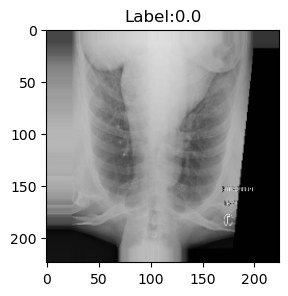

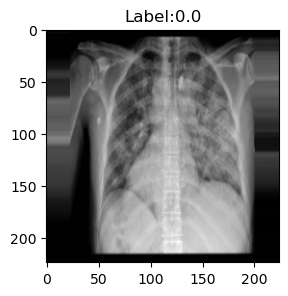

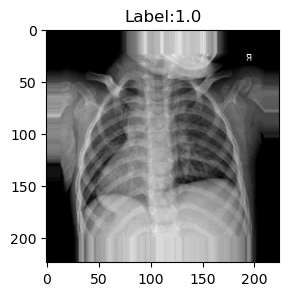

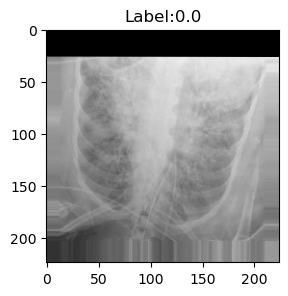

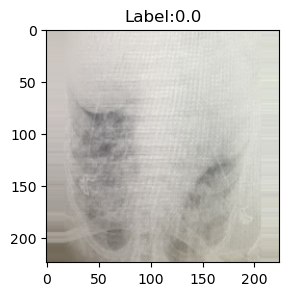

In [17]:
train_image,train_label = next(train_data)
n = 5
for i in range(n):
    plt.figure(figsize=(3,7))
    plt.imshow(train_image[i])
    plt.title(f"Label:{train_label[i]}")
    

# 2) Creating VGG16 model with non-trainable layers

In [18]:
vgg_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    classes="binary",
    input_shape=(Height,Width,Channels)
)

for layer in vgg_model.layers:
    layer.trainable = False

# 3) Adding Vgg model to Sequential model and then adding Full Connection

In [19]:
model = tf.keras.models.Sequential()

model.add(vgg_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=64,activation="relu"))
model.add(tf.keras.layers.Dense(units=128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=256,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=62,activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [21]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 4) Training

In [22]:
history = model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=11
)

Epoch 1/11
9/9 [==============================] - 89s 10s/step - loss: 0.5301 - accuracy: 0.7292 - val_loss: 0.3203 - val_accuracy: 0.9000
Epoch 2/11
9/9 [==============================] - 88s 10s/step - loss: 0.2090 - accuracy: 0.9167 - val_loss: 0.1760 - val_accuracy: 0.9167
Epoch 3/11
9/9 [==============================] - 90s 10s/step - loss: 0.1359 - accuracy: 0.9514 - val_loss: 0.0794 - val_accuracy: 0.9667
Epoch 4/11
9/9 [==============================] - 86s 10s/step - loss: 0.1226 - accuracy: 0.9583 - val_loss: 0.0862 - val_accuracy: 0.9667
Epoch 5/11
9/9 [==============================] - 85s 10s/step - loss: 0.0875 - accuracy: 0.9653 - val_loss: 0.0635 - val_accuracy: 0.9667
Epoch 6/11
9/9 [==============================] - 86s 10s/step - loss: 0.0713 - accuracy: 0.9722 - val_loss: 0.1208 - val_accuracy: 0.9667
Epoch 7/11
9/9 [==============================] - 102s 12s/step - loss: 0.1026 - accuracy: 0.9583 - val_loss: 0.0688 - val_accuracy: 0.9833
Epoch 8/11
9/9 [==========

In [23]:
def display_History(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epoch = range(1,len(acc)+1)
    
    fig,axes = plt.subplots(1,2,figsize=(16,7),dpi=179)
    axes[0].plot(epoch,acc,"o--",label="Train Accuracy")
    axes[0].plot(epoch,val_acc,"rD:",label="Validation Accuracy")
    axes[0].set_xlabel("Epochs",fontsize=19)
    axes[0].set_ylabel("Accuracy",fontsize=19)
    axes[0].set_title("Accuracy vs Epochs",fontsize=19)
    axes[0].legend()
    
    
    axes[1].plot(epoch,loss,"o--",label="Train Loss")
    axes[1].plot(epoch,val_loss,"rD:",label="Validation Loss")
    axes[1].set_xlabel("Epochs",fontsize=19)
    axes[1].set_ylabel("Loss",fontsize=19)
    axes[1].set_title("Loss vs Epochs",fontsize=19)
    axes[1].legend()

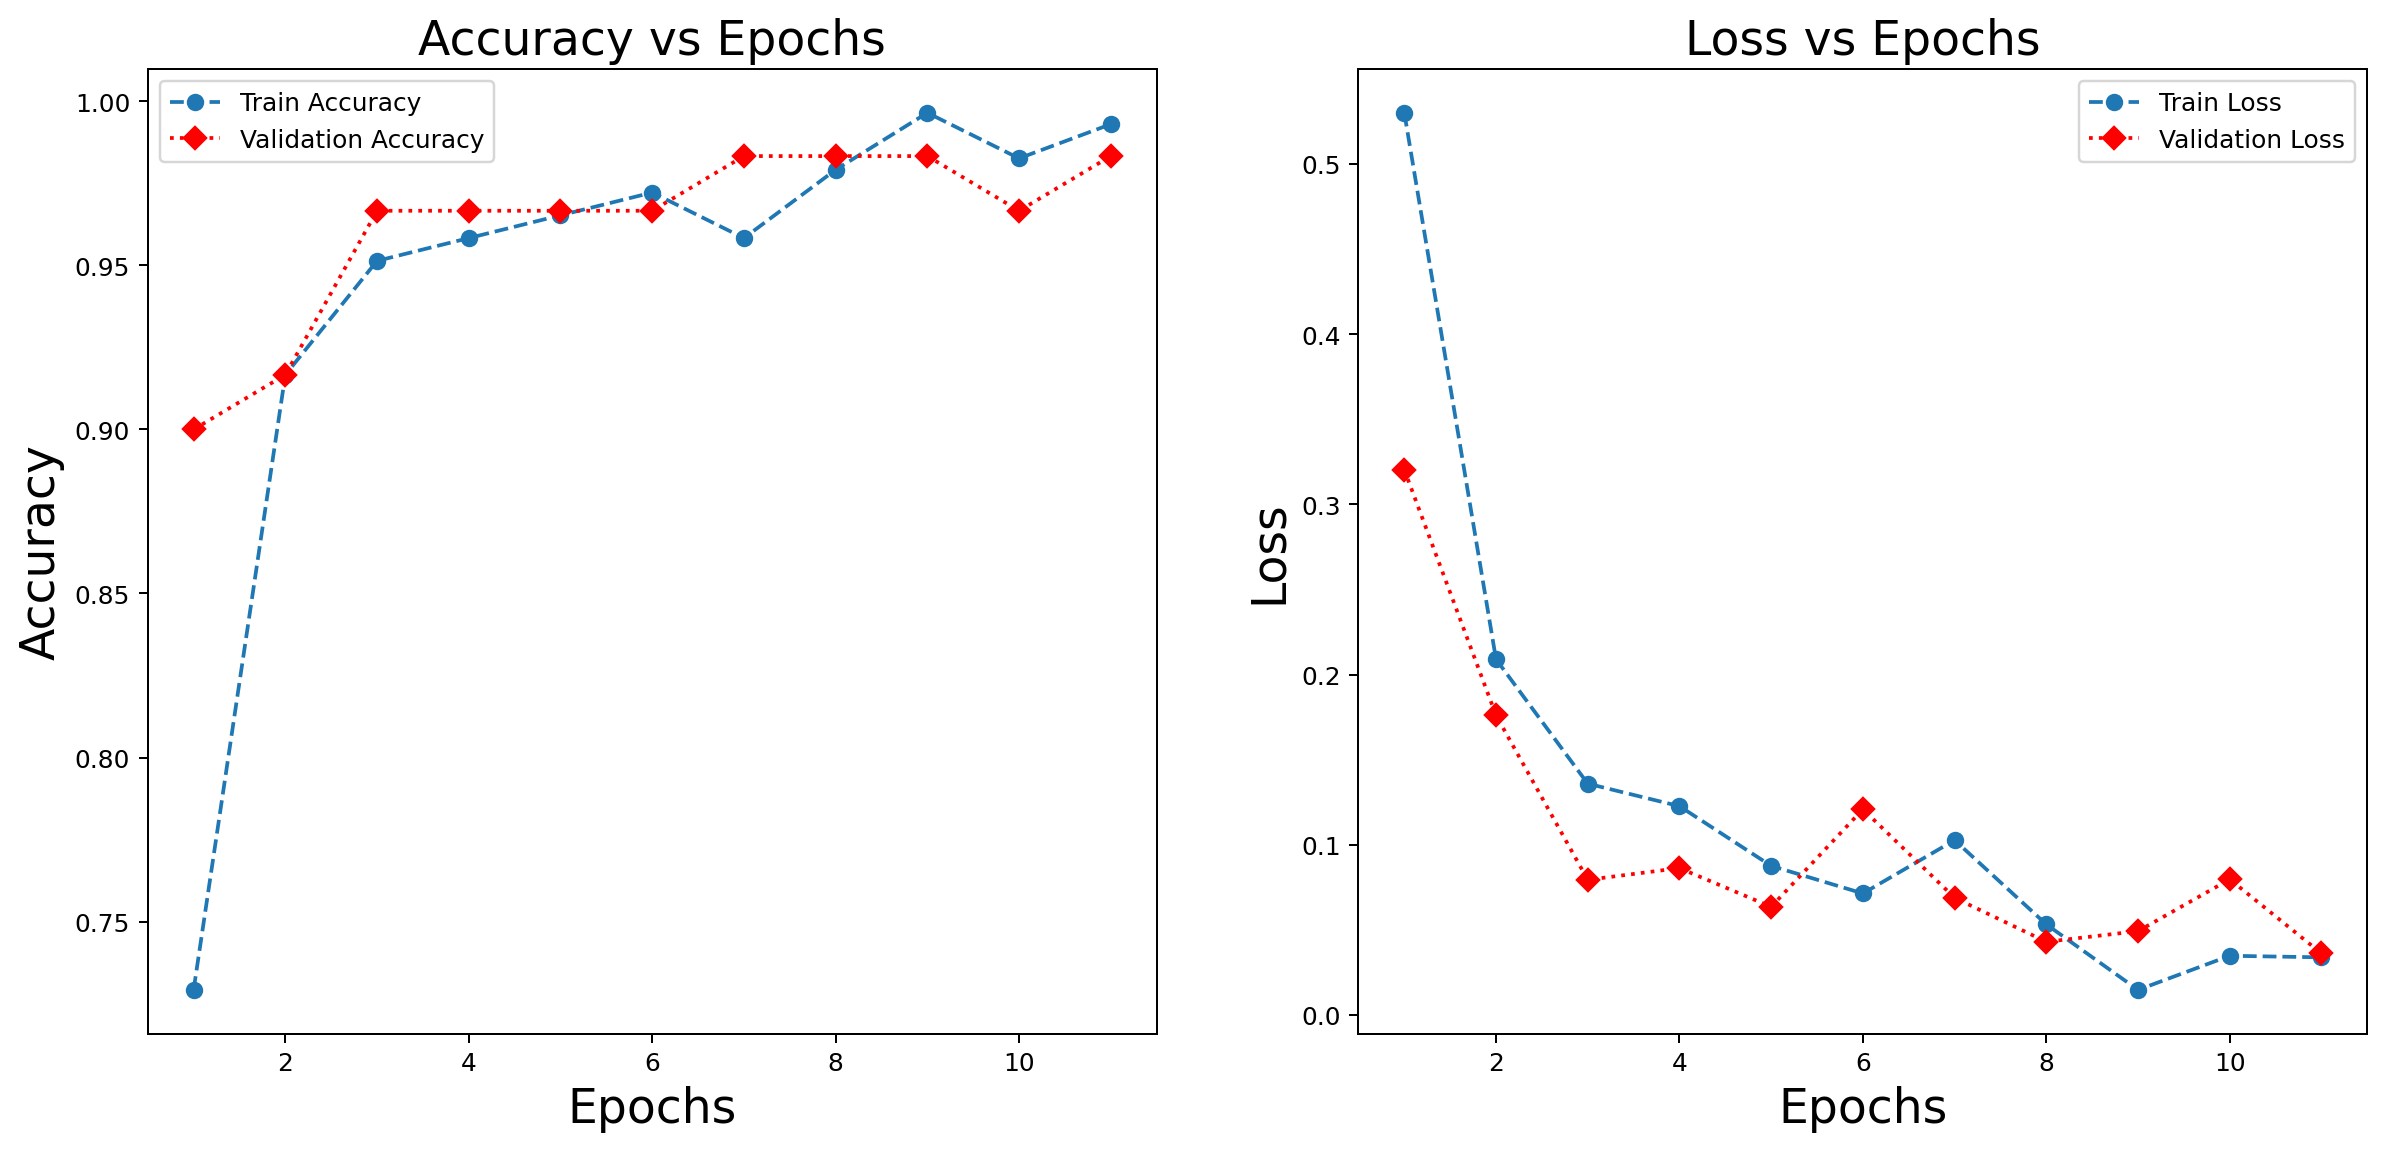

In [24]:
display_History(history)

In [25]:
model.evaluate(train_data)

9/9 [==============================] - 90s 10s/step - loss: 0.0204 - accuracy: 0.9931


[0.020407166332006454, 0.9930555820465088]

In [26]:
model.evaluate(val_data)

2/2 [==============================] - 16s 8s/step - loss: 0.0361 - accuracy: 0.9833


[0.03606167808175087, 0.9833333492279053]

In [27]:
model.evaluate(test_data)

2/2 [==============================] - 14s 5s/step - loss: 0.1641 - accuracy: 0.9623


[0.1640511304140091, 0.9622641801834106]

In [28]:
y_pred = [1 if val > 0.5 else 0 for val in model.predict(test_data)]

2/2 [==============================] - 13s 5s/step


# 5) Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.94      0.97        32

    accuracy                           0.96        53
   macro avg       0.96      0.97      0.96        53
weighted avg       0.97      0.96      0.96        53



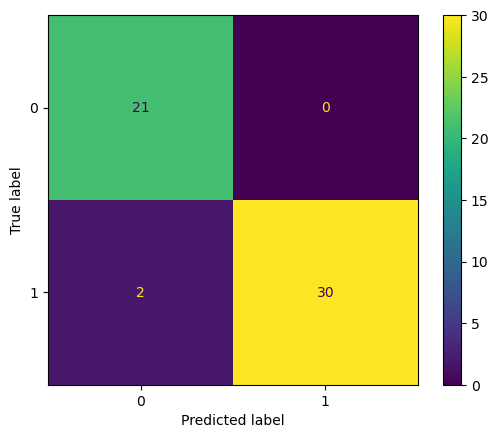

In [29]:
print(classification_report(test_data.labels,y_pred))
d = ConfusionMatrixDisplay(confusion_matrix(test_data.labels,y_pred))
d.plot();